In [1]:
from types import *
from dataloader import *
from util import *
from graphs import *
from agreement import *
from scoring import *

# There's also 'tutorial' and 'preliminary' data
data = load_data('../annotated', batch_num=[5, 6], preprocess=True)

# NOTE: Unlike past data collection, the sentences have been randomized
# among annotators, meaning analysis which averages across sentences or calculates
# inter-annotator agreement may be wrong. Need to fix dataloading to re-sort sentences
# with the same annotators together.

Loading files: ['../annotated/batch_5_anton.json', '../annotated/batch_5_ayush.json', '../annotated/batch_5_kelly.json', '../annotated/batch_5_rachel.json', '../annotated/batch_5_vinayak.json', '../annotated/batch_5_vishnesh.json', '../annotated/batch_6_anton.json', '../annotated/batch_6_ayush.json', '../annotated/batch_6_kelly.json', '../annotated/batch_6_vinayak.json', '../annotated/batch_6_vishnesh.json']

Found users: {'rachel', 'kelly', 'ayush', 'vishnesh', 'anton', 'vinayak'}

anton - Batch 5, HIT 38 (ID 37) has 2 deletion edits but 1 annotations. Likely a missing annotation. Skipping edit type...
vinayak - Batch 6, HIT 16 (ID 45) has 1 insertion edits but -1 annotations. Likely a missing annotation. Skipping edit type...
rachel - Batch 5, HIT 21 (ID 65) has 4 deletion edits but 3 annotations. Likely a missing annotation. Skipping edit type...
rachel - Batch 5, HIT 21 (ID 65) has 4 insertion edits but 3 annotations. Likely a missing annotation. Skipping edit type...
rachel - Batc

In [2]:
# Print spans with comments
get_comments(data)

ANTON - HIT 3: no change


AYUSH - HIT 105: Annotating this was kind of hard, not sure how to show concatenation with the current taxonomy

ANTON - HIT 108: 



In [3]:
# The systems we looked at
systems = set([x['system'] for x in data])

# Edit types
edit_types = set(data[0]['annotations'].keys())

In [4]:
# Example: Searches for coreference errors
deletions = [process_annotation(k) for k in [i for j in [[x for x in sent['edits'] if x['type'] == 'deletion'] for sent in data] for i in j]]
for d in deletions:
    if d['error_type'] == Error.COREFERENCE:
        print(d)

In [5]:
# Example: Some of the annotations for sentence 0
data[0]['processed_annotations'][:2]

[{'edit_type': 'deletion',
  'id': 0,
  'information_impact': <Information.LESS: 'Generalization'>,
  'type': <Quality.QUALITY: 'No Error'>,
  'family': <Family.CONTENT: 'Content'>,
  'grammar_error': False,
  'error_type': None,
  'rating': 3,
  'size': 0.008310249307479225,
  'reorder_level': None,
  'score': 0.970747553725849},
 {'edit_type': 'deletion',
  'id': 1,
  'information_impact': <Information.LESS: 'Generalization'>,
  'type': <Quality.QUALITY: 'No Error'>,
  'family': <Family.CONTENT: 'Content'>,
  'grammar_error': False,
  'error_type': None,
  'rating': 2,
  'size': 0.030470914127423823,
  'reorder_level': None,
  'score': 0.8085959365626684}]

In [6]:
# Example: Some of the edits for sentence 0
data[0]['edits'][:2]

[{'type': 'deletion',
  'id': 0,
  'original_span': [(92, 95)],
  'simplified_span': None,
  'annotation': ['perfect', 'no', 'no']},
 {'type': 'deletion',
  'id': 1,
  'original_span': [(113, 124)],
  'simplified_span': None,
  'annotation': ['good', 'no', 'no']}]

In [7]:
# Example: Agreement between annotators on edit types
# for edit_type in ['deletion', 'insertion', 'reorder', 'substitution']:
#     print(f'{edit_type} -> {calculate_agreement(data, edit_type, drop_no_spans=True)}')

In [8]:
# TODO: trivial edits on substitutions aren't being processed correctly
# for sent in data:
#     for ann in sent['processed_annotations']:
#         if ann['type'] == Quality.TRIVIAL and ann['rating'] == None:
#             print(sent['id'])
#             print([e for e in sent['edits'] if e['type'] == 'substitution'])
#             print(ann)
#             print(sent['system'])
#             print(sent['system'])
#             print(sent['user'])

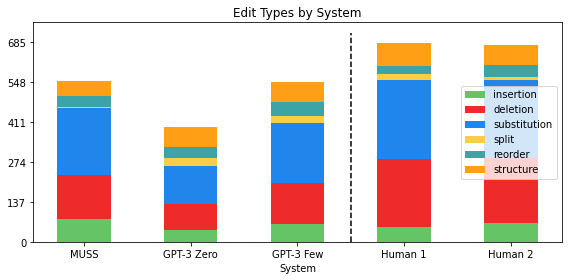

In [9]:
edit_type_by_system(data, flipped=True)

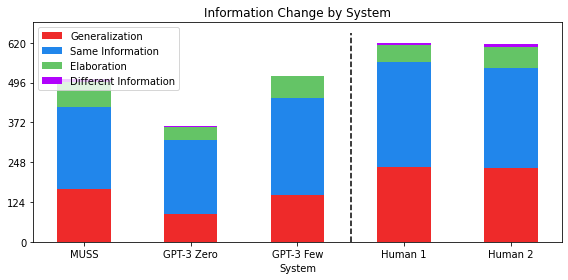

In [10]:
system_by_information_change(data)

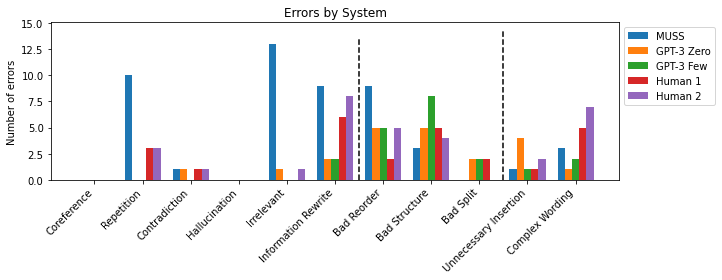

In [11]:
errors_by_system(data)

In [12]:
sankey_combined(data)

In [13]:
# Prints the sentences where annotators identified insertion errors
for error in [Error.REPETITION, Error.CONTRADICTION, Error.HALLUCINATION, Error.IRRELEVANT]:
    print(f'\n{error.value}')
    for sent in data:
        for ann in sent['processed_annotations']:
            if ann['error_type'] == error:
                print(f'{get_sent_info(sent)} \t {system_name_mapping[sent["system"]]}')


Repetition
rachel - Batch 5, HIT 6 (ID 9) 	 Human 1
vinayak - Batch 6, HIT 22 (ID 21) 	 Human 2
vinayak - Batch 6, HIT 17 (ID 46) 	 Human 2
vinayak - Batch 6, HIT 8 (ID 69) 	 MUSS
rachel - Batch 5, HIT 18 (ID 76) 	 MUSS
vishnesh - Batch 5, HIT 39 (ID 76) 	 MUSS
vinayak - Batch 6, HIT 33 (ID 77) 	 Human 1
rachel - Batch 5, HIT 34 (ID 87) 	 MUSS
rachel - Batch 5, HIT 38 (ID 91) 	 MUSS
ayush - Batch 6, HIT 17 (ID 105) 	 Human 2
anton - Batch 6, HIT 29 (ID 127) 	 MUSS
ayush - Batch 6, HIT 28 (ID 127) 	 MUSS
ayush - Batch 6, HIT 29 (ID 128) 	 Human 1
ayush - Batch 6, HIT 4 (ID 137) 	 MUSS
kelly - Batch 6, HIT 9 (ID 137) 	 MUSS
vishnesh - Batch 6, HIT 19 (ID 137) 	 MUSS

Contradiction
vinayak - Batch 6, HIT 4 (ID 4) 	 MUSS
rachel - Batch 5, HIT 8 (ID 5) 	 GPT-3 Zero
rachel - Batch 5, HIT 26 (ID 79) 	 Human 1
ayush - Batch 6, HIT 7 (ID 95) 	 Human 2

Hallucination

Irrelevant
anton - Batch 5, HIT 5 (ID 4) 	 MUSS
anton - Batch 5, HIT 13 (ID 12) 	 MUSS
kelly - Batch 5, HIT 13 (ID 12) 	 MUSS
ke

In [14]:
# Print the avg. sentence scores for each system
for s in systems:
    print(f'{system_name_mapping[s]} \t {avg([sent["score"] for sent in data if sent["system"] == s])}')

GPT-3 Few 	 10.09
GPT-3 Zero 	 6.75
Human 1 	 11.22
MUSS 	 6.25
Human 2 	 12.61


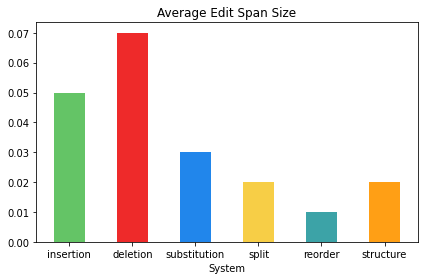

In [15]:
annotations = [x for y in [sent['processed_annotations'] for sent in data] for x in y]
avg_span_size(annotations)

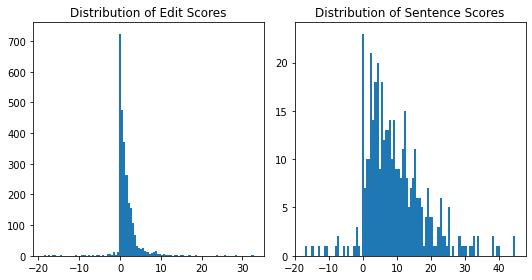

In [16]:
# Show the distribution of edit and sentence scores
score_distribution(data)

In [17]:
# Get the best and worst performing sentences
best, worst = best_performing(data)

Highest Scoring:
vishnesh - Batch 6, HIT 32 (ID 130) - 44.74048122070516
vinayak - Batch 6, HIT 16 (ID 45) - 44.49183097534004
anton - Batch 5, HIT 40 (ID 39) - 40.218971182996725
vinayak - Batch 5, HIT 33 (ID 111) - 39.33684930275075
vinayak - Batch 5, HIT 7 (ID 95) - 38.370866195271674

Lowest scoring:
anton - Batch 5, HIT 29 (ID 28) - -16.917285069615684
ayush - Batch 6, HIT 2 (ID 135) - -14.600727188758242
anton - Batch 5, HIT 25 (ID 24) - -13.068003037735588
anton - Batch 6, HIT 29 (ID 127) - -10.850466165383933
anton - Batch 6, HIT 16 (ID 114) - -10.57465641534539


In [18]:
# Get setences with a score of 0
zeros = zero_scoring_sents(data)

anton - Batch 5, HIT 19 (ID 18)
ayush - Batch 5, HIT 14 (ID 18)
vinayak - Batch 6, HIT 10 (ID 72)


In [19]:
# edit_length(data, systems, simpeval=True)

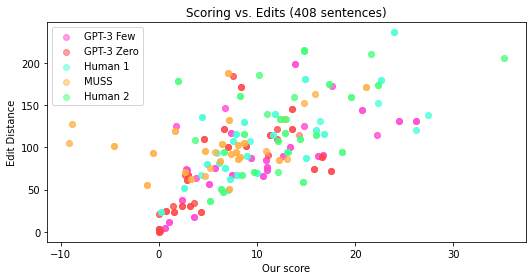

In [20]:
# Averages our scores before plotting
import copy
new_data = copy.deepcopy(data)

for id_ in set([sent['id'] for sent in data]):
    sents = [sent for sent in data if sent['id'] == id_]
    new_score = avg([sent['score'] for sent in sents])
    for i in range(len(new_data)):
        if new_data[i]['id'] == id_:
            new_data[i]['score'] = new_score
            
edit_length(new_data, systems, simpeval=False)

In [21]:
# Get sentences with at least 1 structure change from 1 annotator
ids = set()
for sent in data:
    if 'structure' in [x['type'] for x in sent['edits']]:
        ids.add(sent['id'])
ids = sorted(list(ids))
print(f'Sentences with at least 1 structure change: {len(ids)} / {len(data)}')

Sentences with at least 1 structure change: 111 / 408


anton - Batch 5, HIT 6 (ID 5)

In Marriages and Infidelities, Oates explicitly alludes to novellas and short stories by earlier writers, making use of either their titles or their themes and adapting them in accordance with her artistic intentions.
In "Marriages and Infidelities," Oates uses the titles and themes from earlier novellas and short stories and adapts them to match her own goals.

rachel - Batch 5, HIT 8 (ID 5)

In Marriages and Infidelities, Oates explicitly alludes to novellas and short stories by earlier writers, making use of either their titles or their themes and adapting them in accordance with her artistic intentions.
In "Marriages and Infidelities," Oates uses the titles and themes from earlier novellas and short stories and adapts them to match her own goals.



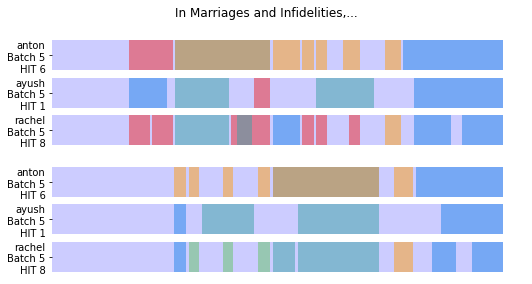

In [22]:
# Display a sentence with a structure change
id_ = 4
sents = [sent for sent in data if sent['id'] == ids[id_]]
print_changes(sents)
draw_agreement(sents)

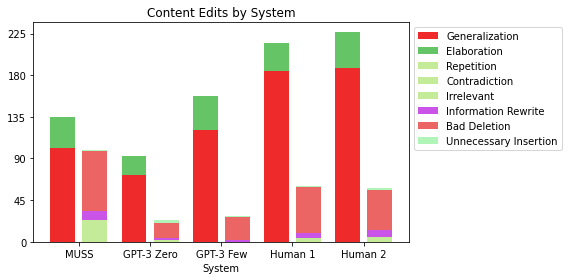

In [23]:
edits_by_family(data, Family.CONTENT)

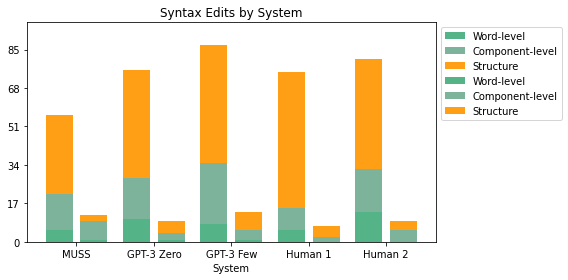

In [24]:
edits_by_family(data, Family.SYNTAX)

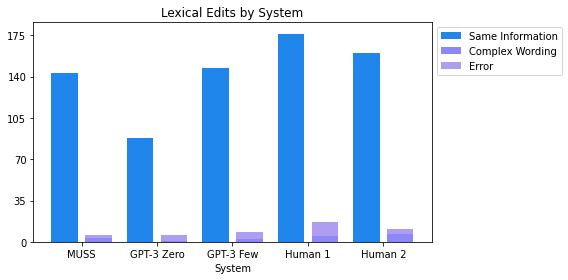

In [25]:
edits_by_family(data, Family.LEXICAL)

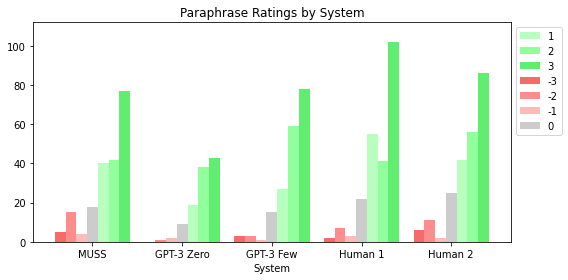

In [26]:
ratings_by_edit_type(data, 'paraphrase')

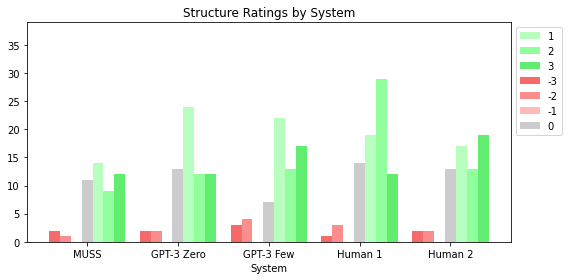

In [27]:
ratings_by_edit_type(data, 'structure')

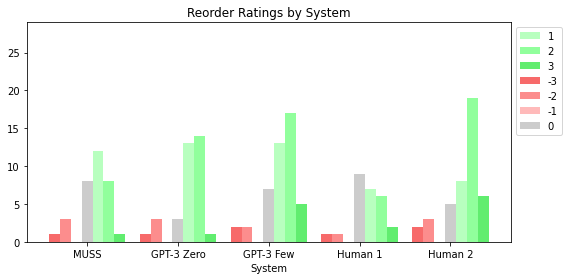

In [28]:
ratings_by_edit_type(data, 'reorder')

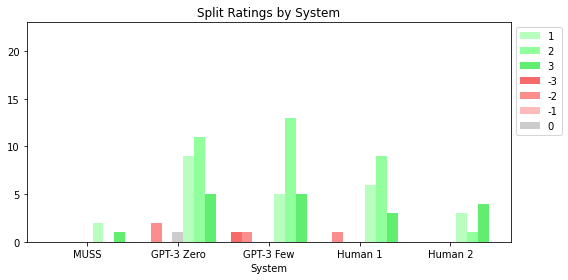

In [29]:
ratings_by_edit_type(data, 'split')

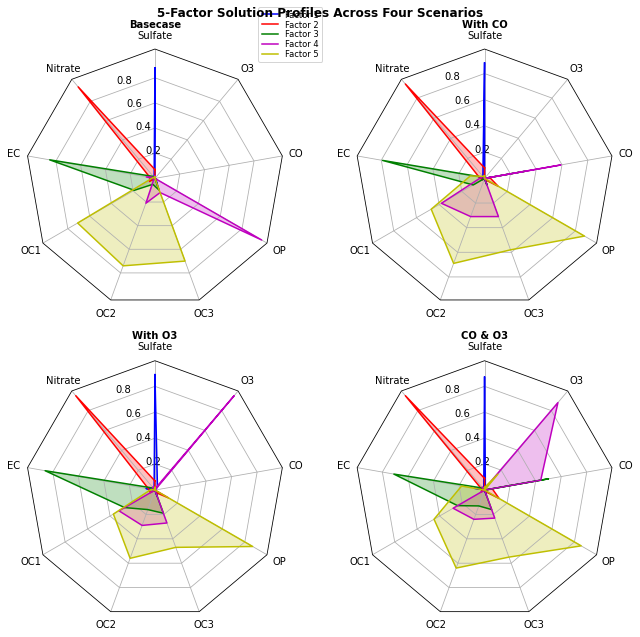

In [33]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


def example_data():
    # The following data is from the Denver Aerosol Sources and Health study.
    # See doi:10.1016/j.atmosenv.2008.12.017
    #
    # The data are pollution source profile estimates for five modeled
    # pollution sources (e.g., cars, wood-burning, etc) that emit 7-9 chemical
    # species. The radar charts are experimented with here to see if we can
    # nicely visualize how the modeled source profiles change across four
    # scenarios:
    #  1) No gas-phase species present, just seven particulate counts on
    #     Sulfate
    #     Nitrate
    #     Elemental Carbon (EC)
    #     Organic Carbon fraction 1 (OC)
    #     Organic Carbon fraction 2 (OC2)
    #     Organic Carbon fraction 3 (OC3)
    #     Pyrolyzed Organic Carbon (OP)
    #  2)Inclusion of gas-phase specie carbon monoxide (CO)
    #  3)Inclusion of gas-phase specie ozone (O3).
    #  4)Inclusion of both gas-phase species is present...
    data = [
        ['Sulfate', 'Nitrate', 'EC', 'OC1', 'OC2', 'OC3', 'OP', 'CO', 'O3'],
        ('Basecase', [
            [0.88, 0.01, 0.03, 0.03, 0.00, 0.06, 0.01, 0.00, 0.00],
            [0.07, 0.95, 0.04, 0.05, 0.00, 0.02, 0.01, 0.00, 0.00],
            [0.01, 0.02, 0.85, 0.19, 0.05, 0.10, 0.00, 0.00, 0.00],
            [0.02, 0.01, 0.07, 0.01, 0.21, 0.12, 0.98, 0.00, 0.00],
            [0.01, 0.01, 0.02, 0.71, 0.74, 0.70, 0.00, 0.00, 0.00]]),
        ('With CO', [
            [0.88, 0.02, 0.02, 0.02, 0.00, 0.05, 0.00, 0.05, 0.00],
            [0.08, 0.94, 0.04, 0.02, 0.00, 0.01, 0.12, 0.04, 0.00],
            [0.01, 0.01, 0.79, 0.10, 0.00, 0.05, 0.00, 0.31, 0.00],
            [0.00, 0.02, 0.03, 0.38, 0.31, 0.31, 0.00, 0.59, 0.00],
            [0.02, 0.02, 0.11, 0.47, 0.69, 0.58, 0.88, 0.00, 0.00]]),
        ('With O3', [
            [0.89, 0.01, 0.07, 0.00, 0.00, 0.05, 0.00, 0.00, 0.03],
            [0.07, 0.95, 0.05, 0.04, 0.00, 0.02, 0.12, 0.00, 0.00],
            [0.01, 0.02, 0.86, 0.27, 0.16, 0.19, 0.00, 0.00, 0.00],
            [0.01, 0.03, 0.00, 0.32, 0.29, 0.27, 0.00, 0.00, 0.95],
            [0.02, 0.00, 0.03, 0.37, 0.56, 0.47, 0.87, 0.00, 0.00]]),
        ('CO & O3', [
            [0.87, 0.01, 0.08, 0.00, 0.00, 0.04, 0.00, 0.00, 0.01],
            [0.09, 0.95, 0.02, 0.03, 0.00, 0.01, 0.13, 0.06, 0.00],
            [0.01, 0.02, 0.71, 0.24, 0.13, 0.16, 0.00, 0.50, 0.00],
            [0.01, 0.03, 0.00, 0.28, 0.24, 0.23, 0.00, 0.44, 0.88],
            [0.02, 0.00, 0.18, 0.45, 0.64, 0.55, 0.86, 0.00, 0.16]])
    ]
    return data

N = 9
theta = radar_factory(N, frame='polygon')

ex_data = example_data()
spoke_labels = ex_data.pop(0)

fig, axs = plt.subplots(figsize=(9, 9), nrows=2, ncols=2,
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

colors = ['b', 'r', 'g', 'm', 'y']
# Plot the four cases from the example data on separate axes
for ax, (title, case_data) in zip(axs.flat, ex_data):
    ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                    horizontalalignment='center', verticalalignment='center')
    for d, color in zip(case_data, colors):
        ax.plot(theta, d, color=color)
        ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
    ax.set_varlabels(spoke_labels)

# add legend relative to top-left plot
labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
legend = axs[0, 0].legend(labels, loc=(0.9, .95),
                            labelspacing=0.1, fontsize='small')

fig.text(0.5, 0.965, '5-Factor Solution Profiles Across Four Scenarios',
            horizontalalignment='center', color='black', weight='bold',
            size='large')

plt.show()

In [ ]:
# - Average quality edit (or log-size * average) rating for these modification types
#     - Content, Syntax, Lexical
#     - Elaboration, Generalization, Paraphrase, Structure, Reorder, Split
# - Average error edit for Content, Syntax, Lexical i guess?
# - Overlap the annotator’s decision for each system

In [31]:
annotator = 'anton'
annotator_data = [sent for sent in data if sent['user'] == annotator]

In [32]:
annotator_data

[{'id': 1,
  'original': "The architecture of Winchester College is a diverse set of architectural styles, reflecting the multiple periods of building from the college's foundation in 1382, through additions in the medieval and Early Modern periods, to a major expansion of accommodation in the Victorian era and then further extensions at the turn of the 20th century and more recently.",
  'original_spans': [[4, 0, 38, 1],
   [1, 39, 41, 1],
   [1, 44, 55, 2],
   [2, 81, 91, 0, 1, 1],
   [0, 92, 95, 1],
   [1, 130, 154, 3],
   [1, 164, 171, 4],
   [1, 182, 184, 6],
   [1, 224, 226, 7],
   [5, 283, 291, 1, 0, 2],
   [5, 292, 342, 1, 4, 1],
   [1, 292, 342, 5],
   [5, 343, 361, 1, 0, 1]],
  'simplified': 'Winchester College’s architecture includes a variety of architectural styles. || This reflects multiple periods of building from when the college was founded in 1382 way until its most recent extensions. || This includes additions made during the medieval and Early Modern periods and a m